In [57]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.special import stirling2
import math
from copy import copy
import scipy

In [2]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

In [3]:
rng = np.random.default_rng(432)

# Setup

In [4]:
def compute_order(alpha):
    '''Sum of elements of a power.'''
    order = 0
    for alpha_i in alpha:
        order += alpha_i
    return order

def compute_Nd(S, d):
    '''Number of moments of order <= d (S species)'''
    Nd = math.factorial(S + d) // (math.factorial(d) * math.factorial(S))
    return Nd

def compute_powers(S, d):
    '''Compute the Nd powers of order <= d (S species)'''

    # all powers
    powers = [[0 for s in range(S)]]

    # powers of order d = 0
    powers_prev = [[0 for s in range(S)]]

    # for order d = 1, ..., d
    for order in range(1, d + 1):

        # store powers of order d
        powers_current = []

        # for each power of order d - 1
        for alpha in powers_prev:

            # for each index
            for i in range(S):

                # add 1 to power at index
                alpha_new = copy(alpha)
                alpha_new[i] += 1

                # store (avoid repeats)
                if alpha_new not in powers_current:
                    powers_current.append(alpha_new)

        # update d - 1 powers
        powers += powers_current

        # update overall powers
        powers_prev = powers_current

    return powers

def add_powers(*powers, S):
    '''Add powers (lists) of size S.'''
    plus = [0 for i in range(S)]
    for i in range(S):
        for power in powers:
            plus[i] += power[i]
    return plus

def falling_factorial(n, k):
    '''FF(n,k) = n(n-1) ... (n - k + 1).'''
    val = 1
    for i in range(k):
        val *= (n - i)
    return val

def binomial_moment(n, p, l):
    '''For X ~ Bin(n, p) compute E[X^l].'''
    val = 0
    for k in range(l + 1):
        val += falling_factorial(n, k) * stirling2(l, k) * p**k
    return val

In [5]:
def bootstrap(sample, d, resamples=None):
    '''
    Compute confidence intervals on the moments of a sample of count pairs, use
    resamples number of bootstrap resamples (default to sample size) and estimate
    moments up to order d.

    Args:
        sample: list of tuples (x1, x2) of integer counts per cell
        d: maximum moment order to estimate
        resamples: integer number of bootstrap resamples to use

    Returns:
        (2 x Nd) numpy array of CI bounds on each Nd moment of order <= d
    '''

    # get sample size
    n = len(sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n

    # helpful values
    powers = compute_powers(S=2, d=d)
    Nd = compute_Nd(S=2, d=d)

    # initialize random generator
    rng = np.random.default_rng()

    # convert string to tuple if neccessary (pandas reading csv to string)
    #if type(sample[0]) == str:
    #    sample = [literal_eval(count_pair) for count_pair in sample]

    # separate sample pairs
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # convert sample to n x 2 array
    sample = np.array([x1_sample, x2_sample]).T

    # bootstrap to N x n x 2 array
    boot = rng.choice(sample, size=(resamples, n))

    # split into 2 N x n arrays
    x1_boot = boot[:, :, 0]
    x2_boot = boot[:, :, 1]

    # estimate
    moment_bounds = np.zeros((2, Nd))
    for i, alpha in enumerate(powers):

        # raise boot to powers
        x1_boot_alpha = x1_boot**alpha[0]
        x2_boot_alpha = x2_boot**alpha[1]

        # multiply (N x n)
        boot_alpha = x1_boot_alpha * x2_boot_alpha

        # mean over sample axis (N x 1)
        moment_estimates = np.mean(boot_alpha, axis=1)

        # quantile over boot axis (2 x 1)
        moment_interval = np.quantile(moment_estimates, [0.025, 0.975])

        # store
        moment_bounds[:, i] = moment_interval

    return moment_bounds

In [6]:
def downsample_data(sample, mean_capture):

    n = len(sample)

    b = (1 / mean_capture) - 1

    # capture efficiency
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=1000)

    # split
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # downsample
    x1_downsample = rng.binomial(x1_sample, beta).tolist()
    x2_downsample = rng.binomial(x2_sample, beta).tolist()

    # combine
    downsample = list(zip(x1_downsample, x2_downsample))

    return downsample, beta

In [7]:
def compute_A(alpha, reactions, vrs, db, R, S, d):
    '''
    Moment equation coefficient matrix
    NOTE: must have order of alpha <= d

    Args:
        alpha: moment order for equation (d/dt mu^alpha = 0)
        reactions: list of strings detailing a_r(x) for each reaction r
        vrs: list of lists detailing v_r for each reaction r
        db: largest order a_r(x)
        R: number of reactions
        S: number of species
        d: maximum moment order used (must be >= order(alpha) + db - 1)

    Returns:
        A: (R, Nd) matrix of coefficients
    '''

    if compute_order(alpha) > d - db + 1:
        raise NotImplementedError(f"Maximum moment order {d} too small for moment equation of alpha = {alpha}: involves moments of higher order.")

    xs = sp.symbols([f'x{i}' for i in range(S)])

    # reaction propensity polynomials
    # props = [eval(str_ar) for str_ar in reactions]
    props = [sp.parse_expr(str_ar, {'xs': xs}) for str_ar in reactions]

    # number of moments of order <= d
    Nd = compute_Nd(S, d)

    # get powers of order <= d
    powers = compute_powers(S, d)

    # setup matrix
    A = np.zeros((R, Nd))

    for r, prop in enumerate(props):

        # expand b(x) * ((x + v_r)**alpha - x**alpha)
        term_1 = 1
        term_2 = 1
        for i in range(S):
            term_1 = term_1 * (xs[i] + vrs[r][i])**alpha[i]
            term_2 = term_2 * xs[i]**alpha[i]
        poly = sp.Poly(prop * (term_1 - term_2), xs)

        # loop over terms
        for xs_power, coeff in zip(poly.monoms(), poly.coeffs()):

            # get matrix index
            col = powers.index(list(xs_power))

            # store
            A[r, col] = coeff

    return A

In [8]:
def compute_B(beta, S, U, d):
    '''
    Capture efficiency moment scaling matrix

    Args:
        beta: per cell capture efficiency sample
        S: number of species
        U: unobserved species indices
        d: maximum moment order used

    Returns:
        B: (Nd, Nd) matrix of coefficients
    '''

    # number of moments of order <= d
    Nd = compute_Nd(S, d)

    # compute powers of order <= d
    powers = compute_powers(S, d)

    # compute beta moments of order <= d
    y_beta = np.zeros(d + 1)
    for l in range(d + 1):
        y_beta[l] = np.mean(beta**l)

    # setup matrix
    B = np.zeros((Nd, Nd))

    p = sp.Symbol('p')
    xs = sp.symbols([f'x{i}' for i in range(S)])

    # for each moment power
    for row, alpha in enumerate(powers):

        # setup polynomail
        poly_alpha = 1

        # for each species
        for i in range(S):

            # unobserved: no capture efficiency
            if i in U:
                moment = xs[i]**alpha[i]

            # observed: compute moment expression for E[Xi^alphai] in xi
            else:
                moment = binomial_moment(xs[i], p, alpha[i])
            
            poly = sp.Poly(moment, p, xs[i])

            # multiply
            poly_alpha = poly_alpha * poly

        # loop over terms
        for (beta_power, *xs_power), coeff in zip(poly_alpha.monoms(), poly_alpha.coeffs()):

            # get matrix index
            col = powers.index(xs_power)

            B[row, col] += coeff * y_beta[beta_power]

    return B

In [9]:
def construct_M_s(y, s, S, d):
    '''Moment matrix variable constructor (s).'''
    if s == 0:
        D = math.floor(d / 2)
    else:
        D = math.floor((d - 1) / 2)
    powers_D = compute_powers(S, D)
    powers_d = compute_powers(S, d)
    ND = compute_Nd(S, D)
    M_s = [[0 for j in range(ND)] for i in range(ND)]
    e_s = [1 if i == (s - 1) else 0 for i in range(S)]
    for alpha_index, alpha in enumerate(powers_D):
        for beta_index, beta in enumerate(powers_D):
            plus = add_powers(alpha, beta, e_s, S=S)
            plus_index = powers_d.index(plus)
            M_s[alpha_index][beta_index] = y[plus_index].item()
    M_s = gp.MVar.fromlist(M_s)
    return M_s

In [10]:
def base_model(model, OB_bounds, beta, reactions, vrs, db, R, S, U, d, constraints, fixed=[], time_limit=300, K=100):
    '''
    Construct 'base model' with semidefinite constraints removed to give NLP

    Args:
        opt: Optimization class (or subclass), see relevant attributes
        model: empty gurobi model object
        OB_bounds: confidence intervals on observed moments up to order d (at least)

        Relevant class attributes

        beta: capture efficiency vector
        reactions: list of strings detailing a_r(x) for each reaction r
        vrs: list of lists detailing v_r for each reaction r
        db: largest order a_r(x)
        R: number of reactions
        S: number of species
        U: indices of unobserved species
        d: maximum moment order used
        fixed: list of pairs of (reaction index r, value to fix k_r to)
        time_limit: optimization time limit

        constraint options

        moment_bounds: CI bounds on moments
        moment_matrices: 
        moment_equations
        factorization
        factorization_telegraph
        telegraph_moments

    Returns:
        model: gurobi model object with NLP constraints (all but semidefinite)
        variables: dict for model variable reference
    '''

    # model settings
    model.Params.TimeLimit = time_limit

    # helpful values
    Nd = compute_Nd(S, d)

    # variables
    y = model.addMVar(shape=Nd, vtype=GRB.CONTINUOUS, name="y", lb=0)
    k = model.addMVar(shape=R, vtype=GRB.CONTINUOUS, name="k", lb=0, ub=K)

    # variable dict
    variables = {
        'y': y,
        'k': k
    }

    if constraints['moment_matrices']:

        # moment matrices
        for s in range(S + 1):
            M_s = construct_M_s(y, s, S, d)
            variables[f'M_{s}'] = M_s
    
    # constraints

    if constraints['moment_bounds']:

        '''
        # get CI bounds on OB moments (up to order d)
        y_lb = OB_bounds[0, :]
        y_ub = OB_bounds[1, :]

        # B scaling matrix
        B = compute_B(opt.dataset.beta, opt.S, opt.U, opt.d)

        # moment bounds
        model.addConstr(B @ y <= y_ub, name="y_UB")
        model.addConstr(B @ y >= y_lb, name="y_LB")
        '''

        # Alternate method:
        # do not adjust bounds (in optimization.py)
        # define downsampled moments y_d = B @ y
        # only explicitly bound observed, leave unobserved unbounded
        # avoids issues with e+100 upper bounds on unobserved moments
        # ------------------------------------------------------------

        # B scaling matrix
        B = compute_B(beta, S, U, d)

        # downsampled moments
        y_D = B @ y

        # bound
        O = [i for i in range(S) if i not in U]
        powers_S = compute_powers(S, d)
        powers_2 = compute_powers(2, d)
        for i, alpha_S in enumerate(powers_S):
            # check if unobserved moment (non-zero power of unobserved species)
            observed = True
            for j, alpha_j in enumerate(alpha_S):
                if (j in U) and (alpha_j > 0):
                    observed = False
            # observed: bound
            if observed:
                alpha_2 = [alpha_S[i] for i in O]
                j = powers_2.index(alpha_2)
                model.addConstr(y_D[i] <= OB_bounds[1, j], name=f"y_{i}_UB")
                model.addConstr(y_D[i] >= OB_bounds[0, j], name=f"y_{i}_LB")

        # -------------------------------------------------------------

    if constraints['moment_equations']:
                   
        # moment equations (order(alpha) <= d - db + 1)
        moment_powers = compute_powers(S, d - db + 1)
        for alpha in moment_powers:
            A_alpha_d = compute_A(alpha, reactions, vrs, db, R, S, d)
            model.addConstr(k.T @ A_alpha_d @ y == 0, name=f"ME_{alpha}_{d}")

    if constraints['factorization']:

        # factorization bounds
        powers = compute_powers(S, d)
        for i, alpha in enumerate(powers):

            # E[X1^a1 X2^a2] = E[X1^a1] E[X2^a2]
            if (alpha[0] > 0) and (alpha[1] > 0):
                j = powers.index([alpha[0], 0])
                l = powers.index([0, alpha[1]])
                model.addConstr(y[i] == y[j] * y[l], name=f"Moment_factorization_{alpha[0]}_({alpha[1]})")

    if constraints['telegraph_factorization']:

        # factorization bounds
        powers = compute_powers(S, d)
        for i, alpha in enumerate(powers):

            # E[X1^a1 X2^a2 G1^a3 G2^a4] = E[X1^a1 G1^a3] E[X2^a2 G2^a4]
            if (alpha[0] > 0) and (alpha[1] > 0):
                j = powers.index([alpha[0], 0, alpha[2], 0])
                l = powers.index([0, alpha[1], 0, alpha[3]])
                model.addConstr(y[i] == y[j] * y[l], name=f"Moment_factorization_{alpha[0], alpha[2]}_({alpha[1], alpha[3]})")

    if constraints['telegraph_moments']:

        # telegraph moment equality (as Gi in {0, 1}, E[Gi^n] = E[Gi] for n > 0, same with cross moments)
        powers = compute_powers(S, d)

        #u = powers.index([0, 0, 1, 0])
        #model.addConstr(y[u] == k[0] / (k[0] + k[1]))

        #v = powers.index([0, 0, 0, 1])
        #model.addConstr(y[v] == k[4] / (k[4] + k[5]))


        for i, alpha in enumerate(powers):

            # G1, G2 powers > 0: equal to powers of 1
            if (alpha[2] > 0) and (alpha[3] > 0):
                j = powers.index([alpha[0], alpha[1], 1, 1])
                model.addConstr(y[i] == y[j], name="Telegraph_moment_equality_G1_G2")
            
            # G1 power > 0: equal to power of 1
            elif (alpha[2] > 0):
                j = powers.index([alpha[0], alpha[1], 1, alpha[3]])
                model.addConstr(y[i] == y[j], name="Telegraph_moment_equality_G1")

            # G2 power > 0: equal to power of 1
            elif (alpha[3] > 0):
                j = powers.index([alpha[0], alpha[1], alpha[2], 1])
                model.addConstr(y[i] == y[j], name="Telegraph_moment_equality_G2")

    if constraints['telegraph_moments_ineq']:

        # telegraph moment inequality (as Gi in {0, 1}, E[... Gi] <= E[...])
        powers = compute_powers(S, d)
        for alpha_1 in range(d + 1):
            for alpha_2 in range(d - alpha_1 + 1):

                # E[... G1 G2] <= E[... G1]
                try:
                    i = powers.index([alpha_1, alpha_2, 1, 1])
                    j = powers.index([alpha_1, alpha_2, 1, 0])
                    model.addConstr(y[i] <= y[j], name="Telegraph_moment_inequality_G1G2_G1")
                except ValueError:
                    pass

                # E[... G1 G2] <= E[... G2]
                try:
                    i = powers.index([alpha_1, alpha_2, 1, 1])
                    r = powers.index([alpha_1, alpha_2, 0, 1])
                    model.addConstr(y[i] <= y[r], name="Telegraph_moment_inequality_G1G2_G2")
                except ValueError:
                    pass

                # E[... G1] <= E[...]
                try:
                    j = powers.index([alpha_1, alpha_2, 1, 0])
                    s = powers.index([alpha_1, alpha_2, 0, 0])
                    model.addConstr(y[j] <= y[s], name="Telegraph_moment_inequality_G1")
                except ValueError:
                    pass

                # E[... G2] <= E[...]
                try:
                    r = powers.index([alpha_1, alpha_2, 0, 1])
                    s = powers.index([alpha_1, alpha_2, 0, 0])
                    model.addConstr(y[r] <= y[s], name="Telegraph_moment_inequality_G2")
                except ValueError:
                    pass

    # fixed moment
    model.addConstr(y[0] == 1, name="y0_base")

    # fixed parameters
    for r, val in fixed:
        model.addConstr(k[r] == val, name=f"k{r}_fixed")

    return model, variables

In [128]:
def optimize(model):
    '''Optimize model with no objective, return status.'''

    # optimize
    model.setObjective(0, GRB.MINIMIZE)
    model.optimize()
    status = status_codes[model.status]

    # get value of all variables
    all_vars = model.getVars()
    try:
        values = model.getAttr("X", all_vars)
    except:
        values = [None for var in all_vars]
    names = model.getAttr("VarName", all_vars)
    var_dict = {name: val for name, val in zip(names, values)}

    return model, status, var_dict

In [12]:
def semidefinite_cut(model, variables, S, print_evals=False, eval_eps=10**-6, printing=False):
    '''
    Check semidefinite feasibility of NLP feasible point
    Feasible: stop
    Infeasible: add cutting plane (ALL negative eigenvalues)

    Args:
        model: optimized NLP model
        variables: model variable reference dict
        print_evals: option to display moment matrix eigenvalues (semidefinite condition)

    Returns:
        model: model with any cutting planes added
        bool: semidefinite feasibility status
    '''

    # data list
    data = []

    # moment matrix values
    for s in range(S + 1):
        data.append(
            {f'M_val': variables[f'M_{s}'].X}
        )

    # eigen information
    for s in range(S + 1):
        evals_s, evecs_s = np.linalg.eigh(data[s]['M_val'])
        data[s]['evals'] = evals_s
        data[s]['evecs'] = evecs_s

    # extract eigenvalue data
    evals_data = {s: data[s]['evals'] for s in range(S + 1)}

    if print_evals:
        print("Moment matices eigenvalues:")
        for s in range(S + 1):
            print(data[s]['evals'])

    # check if all positive eigenvalues
    positive = True
    for s in range(S + 1):
        if not (data[s]['evals'] >= -eval_eps).all():
            positive = False
            break

    # positive eigenvalues
    if positive:

        if printing: print("SDP feasible\n")
    
        return model, True, evals_data

    # negative eigenvalue
    else:

        if printing: print("SDP infeasible\n")

        # for each matrix
        for s in range(S + 1):

            # for each M_s eigenvalue
            for i, lam in enumerate(data[s]['evals']):

                # if negative (sufficiently)
                if lam < -eval_eps:

                    # get evector
                    v = data[s]['evecs'][:, i]

                    # add cutting plane
                    #model.addConstr(np.kron(v, v.T) @ variables[f'M_{s}'].reshape(-1) >= 0, name=f"Cut_{s}")
                    model.addConstr(v.T @ variables[f'M_{s}'] @ v >= 0, name=f"Cut_{s}")
                
                    if printing: print(f"M_{s} cut added")

        if printing: print("")

    return model, False, evals_data

In [13]:
def feasibility_test(OB_bounds, beta, reactions, vrs, db, R, S, U, d, constraints, fixed=[],
                     time_limit=300, K=100, print_evals=False, eval_eps=10**-6, printing=False,
                     silent=True, write_model=False, cut_limit=100, total_time_limit=300):
    '''
    Full feasibility test of birth death model via following algorithm

    Optimize NLP
    Infeasible: stop
    Feasible: check SDP feasibility
        Feasible: stop
        Infeasible: add cutting plane and return to NLP step
    '''

    # store information from SDP loop
    eigenvalues = []
    optim_times = []
    feasible_values = []

    # get moment bounds for sample i
    # OB_bounds = self.dataset.moment_bounds[f'sample-{i}']

    # raise exception if moments not available
    #if self.d > self.dataset.d:
    #    raise Exception(f"Optimization d = {self.d} too high for dataset d = {self.dataset.d}")
    
    # adjust S = 2, U = [] bounds to optimization S, U (up to order d)
    # OB_bounds = optimization_utils.bounds_adjust(OB_bounds, self.S, self.U, self.d)

    # if provided load WLS license credentials
    #if self.license_file:
    #    environment_parameters = json.load(open(self.license_file))
    # otherwise use default environment (e.g Named User license)
    #else:
    environment_parameters = {}

    # silence output
    if silent:
        environment_parameters['OutputFlag'] = 0

    # environment context
    with gp.Env(params=environment_parameters) as env:

        # model context
        with gp.Model('test-SDP', env=env) as model:

            # construct base model (no semidefinite constraints)
            model, variables = base_model(model, OB_bounds, beta, reactions, vrs, db, R, S, U, d, constraints, fixed=fixed, time_limit=time_limit, K=K)

            # write model
            if write_model:
                model.write('model.lp')
            
            # check feasibility
            model, status, var_dict = optimize(model)

            # collect solution information
            solution = {
                'status': status,
                'time': model.Runtime,
                'cuts': 0
            }

            optim_times.append(solution['time'])
            feasible_values.append(var_dict)

            # no semidefinite constraints or non-optimal solution: return NLP status
            if not (constraints['moment_matrices'] and status == "OPTIMAL"):

                return solution, eigenvalues, optim_times, feasible_values

            # while below time and cut limit
            while (solution['cuts'] < cut_limit) and (solution['time'] < total_time_limit):

                # check semidefinite feasibility & add cuts if needed
                model, semidefinite_feas, evals_data = semidefinite_cut(model, variables, S, print_evals, eval_eps, printing)

                # store eigenvalue & optim time data
                eigenvalues.append(evals_data)
                optim_times.append(model.Runtime)

                # semidefinite feasible: return
                if semidefinite_feas:

                    return solution, eigenvalues, optim_times, feasible_values
                
                # record cut
                solution['cuts'] += 1
                
                # semidefinite infeasible: check NLP feasibility with added cut
                model, status, var_dict = optimize(model)

                # update optimization time
                solution['time'] += model.Runtime
                feasible_values.append(var_dict)

                # NLP + cut infeasible: return
                # (also return for any other status, can only proceed if optimal as need feasible point)
                if not (status == "OPTIMAL"):

                    # update solution
                    solution['status'] = status

                    return solution, eigenvalues, optim_times, feasible_values

            # set custom status
            if solution['cuts'] >= cut_limit:

                # exceeded number of cutting plane iterations
                solution['status'] = "CUT_LIMIT"
            
            elif solution['time'] >= total_time_limit:

                # exceeded total optimization time
                solution['status'] = "TOTAL_TIME_LIMIT"

            # print
            #if printing:
            #    print(f"Optimization status: {solution['status']}")
            #    print(f"Runtime: {solution['time']}")

            return solution, eigenvalues, optim_times, feasible_values

# Analysis functions

In [14]:
from interaction_inference.simulation import gillespie_telegraph

In [15]:
def simulate(k_on, k_off, k_tx, k_deg, k_reg):

    # settings
    n = 1000

    # sample
    params = {
        'k_on_1': k_on,
        'k_on_2': k_on,
        'k_off_1': k_off,
        'k_off_2': k_off,
        'k_tx_1': k_tx,
        'k_tx_2': k_tx,
        'k_deg_1': k_deg,
        'k_deg_2': k_deg,
        'k_reg': k_reg
    }

    sample = gillespie_telegraph(params, n)

    # mean expression level
    print(f"Mean expression {np.mean(sample, axis=0)}")

    return sample

In [16]:
def downsample(sample, mean_capture):
    
    # downsample
    downsample, beta = downsample_data(sample, mean_capture)

    # mean expression level
    print(f"Mean expression {np.mean(downsample, axis=0)}")

    return downsample, beta

In [88]:
def feasibility_TE(sample, beta, d, printing=False, silent=True, cut_limit=100, total_time_limit=300):
    
    # settings
    reactions = [
        "1 - xs[2]",
        "xs[2]",
        "xs[2]",
        "xs[0]",
        "1 - xs[3]",
        "xs[3]",
        "xs[3]",
        "xs[1]",
        "xs[0] * xs[1]"
    ]
    vrs = [
        [0, 0, 1, 0],
        [0, 0, -1, 0],
        [1, 0, 0, 0],
        [-1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, -1],
        [0, 1, 0, 0],
        [0, -1, 0, 0],
        [-1, -1, 0, 0]
    ]
    db = 2
    R = 9
    S = 4
    U = [2, 3]
    # d = 6
    fixed = [(7, 1)] #[(3, 1), (7, 1), (8, 0)]

    # constraints
    constraints = {
        'moment_bounds':           True,
        'moment_matrices':         True,
        'moment_equations':        True,
        'factorization':           False,
        'telegraph_factorization': False,
        'telegraph_moments':       True,
        'telegraph_moments_ineq':  True
    }

    # bootstrap
    N = 1000
    OB_bounds = bootstrap(sample, d, N)

    # test feasibility
    solution, eigenvalues, optim_times, feasible_values = feasibility_test(
        OB_bounds,
        beta,
        reactions,
        vrs,
        db,
        R,
        S,
        U, 
        d,
        constraints,
        fixed=fixed,
        time_limit=300,
        K=100,
        print_evals=False,
        eval_eps=10**-6,
        printing=printing,
        silent=silent,
        write_model=False,
        cut_limit=cut_limit,
        total_time_limit=total_time_limit
    )

    return solution, eigenvalues, optim_times, feasible_values

In [98]:
def feasibility_BD(sample, beta, d, printing=False, silent=True, cut_limit=100, total_time_limit=300):
    
    # settings
    reactions = [
        "1",
        "xs[0]",
        "1",
        "xs[1]",
        "xs[0] * xs[1]"
    ]
    vrs = [
        [1, 0],
        [-1, 0],
        [0, 1],
        [0, -1],
        [-1, -1]
    ]
    db = 2
    R = 5
    S = 2
    U = []
    # d = 6
    fixed = [(1, 1)]

    # constraints
    constraints = {
        'moment_bounds':           True,
        'moment_matrices':         True,
        'moment_equations':        True,
        'factorization':           False,
        'telegraph_factorization': False,
        'telegraph_moments':       False,
        'telegraph_moments_ineq':  False
    }
    # bootstrap
    N = 1000
    OB_bounds = bootstrap(sample, d, N)

    # test feasibility
    solution, eigenvalues, optim_times, feasible_values = feasibility_test(
        OB_bounds,
        beta,
        reactions,
        vrs,
        db,
        R,
        S,
        U, 
        d,
        constraints,
        fixed=fixed,
        time_limit=300,
        K=100,
        print_evals=False,
        eval_eps=10**-6,
        printing=printing,
        silent=silent,
        write_model=False,
        cut_limit=cut_limit,
        total_time_limit=total_time_limit
    )

    return solution, eigenvalues, optim_times, feasible_values

In [80]:
def plot_eigenvalues(eigenvalues, S=4, log=False):

    fig, axs = plt.subplots(1, S + 1, figsize=(3 * S, 4))
    for s in range(S + 1):
        num_evals = len(eigenvalues[0][s])
        evals_s = [[] for _ in range(num_evals)]
        for data in eigenvalues:
            for i in range(num_evals):
                val = float(data[s][i])
                if val < 0:
                    if log: val = np.log10(-val)
                    evals_s[i].append(val)
        for i in range(num_evals):
            axs[s].plot(evals_s[i], label=f"i = {i}")
        axs[s].set_title(f"M_{s}")
        # plt.legend()
    axs[S // 2].set_xlabel("SDP cutting loop iterations")
    axs[0].set_ylabel("Eigenvalues")
    plt.suptitle("Negative Eigenvalues")
    plt.show()

In [81]:
def plot_times(optim_times):

    plt.figure(figsize=(6, 4))
    plt.plot(optim_times)
    plt.xlabel("Cutting plane loop iterations")
    plt.ylabel("Optimization time")
    plt.show()

In [82]:
def plot_correlation(feasible_values, d, S=4):

    powers = compute_powers(S=S, d=d)

    if S == 4:
        i_xy = powers.index([1, 1, 0, 0])
        i_x  = powers.index([1, 0, 0, 0])
        i_y  = powers.index([0, 1, 0, 0])
        i_x2 = powers.index([2, 0, 0, 0])
        i_y2 = powers.index([0, 2, 0, 0])
    elif S == 2:
        i_xy = powers.index([1, 1])
        i_x  = powers.index([1, 0])
        i_y  = powers.index([0, 1])
        i_x2 = powers.index([2, 0])
        i_y2 = powers.index([0, 2])

    correlations = []

    for var_dict in feasible_values:

        E_xy = var_dict[f'y[{i_xy}]']
        E_x  = var_dict[f'y[{i_x}]']
        E_y  = var_dict[f'y[{i_y}]']
        E_x2 = var_dict[f'y[{i_x2}]']
        E_y2 = var_dict[f'y[{i_y2}]']

        rho = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))

        correlations.append(rho)

    plt.plot(correlations)
    plt.axhline(correlations[-1], color="red", label=f"Final correlation = {correlations[-1]}")
    plt.xlabel("Cutting plane loop iteration")
    plt.ylabel("Correlation of NLP feasible points")
    plt.legend()
    plt.show()

    return correlations

In [83]:
def correlation_test(sample, printing=True):

    # separate pairs into individual samples
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # test
    pearson = scipy.stats.pearsonr(x1_sample, x2_sample, alternative="less")
    rho = pearson.statistic
    p = pearson.pvalue

    if printing: print(f"Correlation {rho} \np-value {p}\n")

    return rho, p

In [101]:
def plot_rates(feasible_values, S=4, printing=True):

    if S == 4:
        K = 9
    elif S == 2:
        K = 5

    k_values = [[] for i in range(K)]
    k_names = ["k_on_1", "k_off_1", "k_tx_1", "k_deg_1", "k_on_2", "k_off_2", "k_tx_2", "k_deg_2", "k_reg"]
    for var_dict in feasible_values:
        for i in range(K):
            k_values[i].append(var_dict[f'k[{i}]'])
    for i in range(K):
        plt.plot(k_values[i], label=k_names[i])
    plt.legend()
    plt.show()

    final_values = [feasible_values[-1][f'k[{i}]'] for i in range(K)]

    if printing:
        print("SDP Feasible reaction rates:")
        for i, k in enumerate(final_values):
            print(f"{k_names[i]} = {k}")

In [139]:
def result_analysis(S, d, eigenvalues, optim_times, feasible_values, sample, dsample, log=False, printing=True):
        
    # plot eigenvalues: show convergence of cutting plane SDP algorithm
    plot_eigenvalues(eigenvalues, S=S, log=log)

    # plot optimization times
    plot_times(optim_times)

    # plot and record correlations at each feasible point
    correlations = plot_correlation(feasible_values, d=d, S=S)

    # plot feasible reaction rates, print final values
    plot_rates(feasible_values, S=S, printing=printing)

    # compare model correlation to data correlation
    print("\n(Model) Original correlation")
    print(f"Correlation {correlations[-1]}\n")
    print("(Data) Original correlation")
    rho, p = correlation_test(sample)
    print("(Data) Downsampled correlation")
    rho_d, p_d = correlation_test(dsample)

# Running

Results
- able to recover original data correlation very well: even if downsampled correlation very different / not sig
    - low ~ 10% capture leading to non-sig correlation: model recovers close to correct -ve value
    - independent data given +ve correlation by downsampling: model recovers close to 0 value
- higher moment orders may be slightly worse at correlation recovery?
    - e.g. true -0.32, d = 5 consistently ~ -0.2, d = 3, 4 consistently ~ -0.3
    - feasible correlation seems to be increasingly +ve with d?
        - d = 3 bit too -ve, d = 5 bit too +ve: d = 4 ~best fit??
- only able to get correlation information when feasible point found
    - e.g. telegraph data under BD model infeasible, get no correlation estimate
    - also only works for interacting models: indep models assume correlation = 0 via factorization
        - this means that for real data: model free test only says if corr ~ 0 or not, int birth-death a.a. infeasible due to overdispersion, so can only get correlation value from int TE (most expensive model)

# Interacting Telegraph Model

### Interacting data

In [155]:
sample = simulate(k_on=1, k_off=0.0, k_tx=2, k_deg=1, k_reg=2)

Mean expression [0.95  0.884]


In [156]:
dsample, beta = downsample(sample, mean_capture=0.5)

Mean expression [0.484 0.43 ]


In [172]:
d = 3
solution, eigenvalues, optim_times, feasible_values = feasibility_TE(dsample, beta, d=d)
solution

{'status': 'OPTIMAL', 'time': 0.019999980926513672, 'cuts': 2}

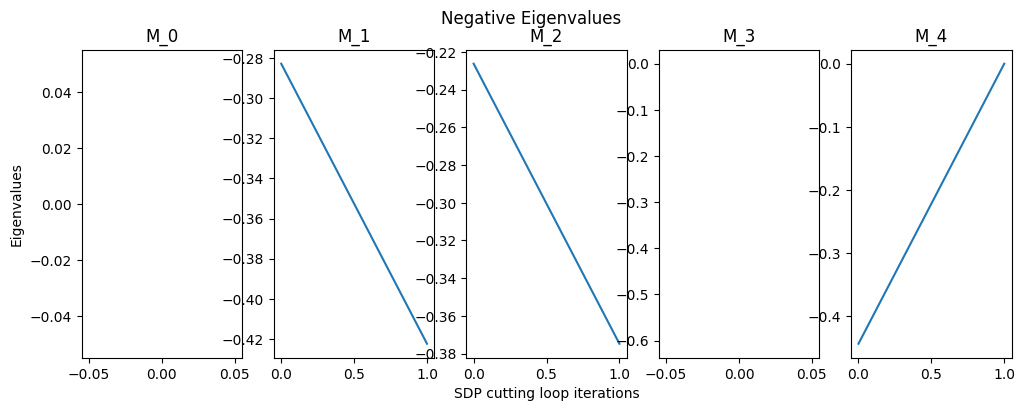

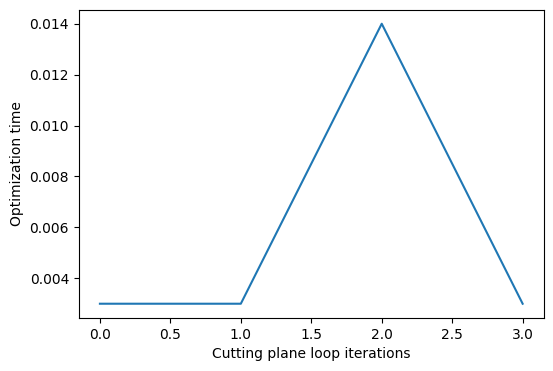

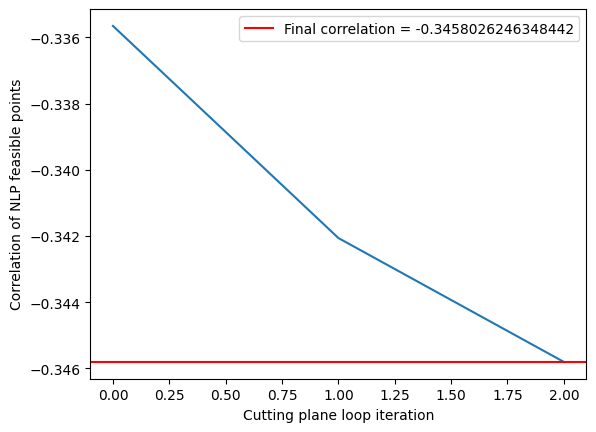

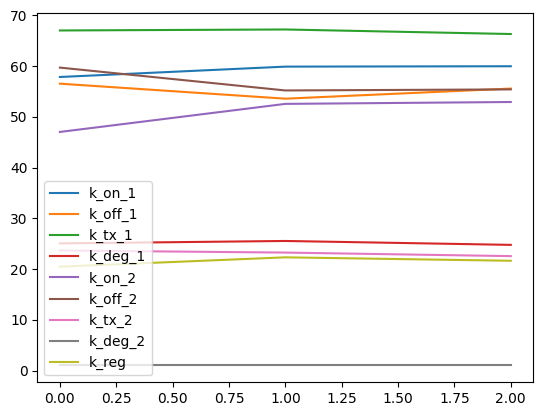

SDP Feasible reaction rates:
k_on_1 = 59.97414432946591
k_off_1 = 55.57434842066747
k_tx_1 = 66.32578109877461
k_deg_1 = 24.76950820761139
k_on_2 = 52.92811593205352
k_off_2 = 55.411587831589564
k_tx_2 = 22.552349153712058
k_deg_2 = 1.0
k_reg = 21.63578205837536

(Model) Original correlation
Correlation -0.3458026246348442

(Data) Original correlation
Correlation -0.3211064315893511 
p-value 1.0183546896067981e-25

(Data) Downsampled correlation
Correlation -0.08353609789790398 
p-value 0.0041092366867322766



In [173]:
S = 4
result_analysis(S, d, eigenvalues, optim_times, feasible_values, sample, dsample)

### Independent data

In [174]:
sample = simulate(k_on=1, k_off=0.0, k_tx=2, k_deg=1, k_reg=0)

Mean expression [1.979 1.999]


In [175]:
dsample, beta = downsample(sample, mean_capture=0.5)

Mean expression [0.983 1.   ]


In [184]:
d = 4
solution, eigenvalues, optim_times, feasible_values = feasibility_TE(dsample, beta, d=d)
solution

{'status': 'OPTIMAL', 'time': 0.04400014877319336, 'cuts': 3}

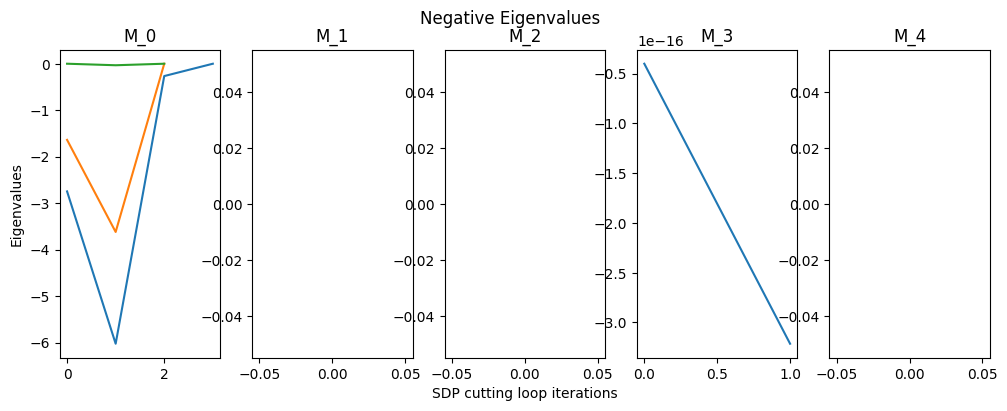

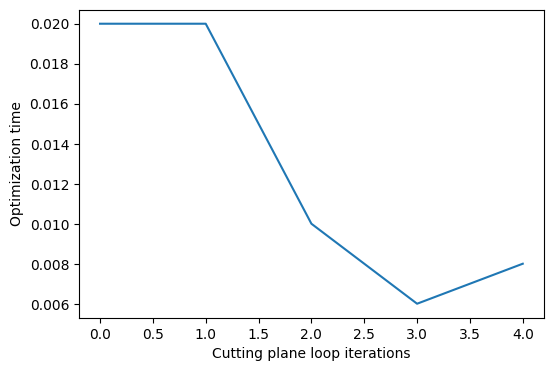

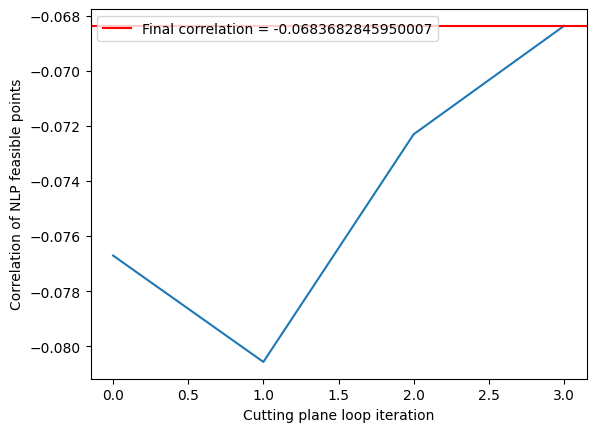

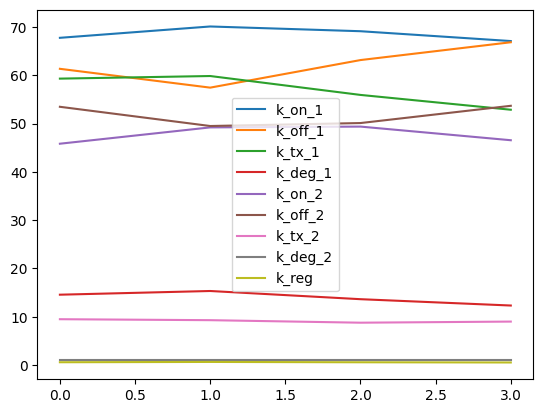

SDP Feasible reaction rates:
k_on_1 = 67.07387831752614
k_off_1 = 66.82541484977253
k_tx_1 = 52.8556663922368
k_deg_1 = 12.319764345060536
k_on_2 = 46.540852512459146
k_off_2 = 53.67030190870622
k_tx_2 = 8.994453187818163
k_deg_2 = 1.0
k_reg = 0.5284745064937628

(Model) Original correlation
Correlation -0.0683682845950007

(Data) Original correlation
Correlation -0.05237475154915425 
p-value 0.04893185420783061

(Data) Downsampled correlation
Correlation 0.2698702331405768 
p-value 1.0



In [185]:
S = 4
result_analysis(S, d, eigenvalues, optim_times, feasible_values, sample, dsample)

# Interacting Birth Death Model

### Birth Death data

In [95]:
sample = simulate(k_on=1, k_off=0.0, k_tx=2, k_deg=1, k_reg=2)

Mean expression [0.949 0.912]


In [103]:
dsample, beta = downsample(sample, mean_capture=0.1)

Mean expression [0.084 0.088]


In [104]:
d = 4
solution, eigenvalues, optim_times, feasible_values = feasibility_BD(dsample, beta, d=d)
solution

{'status': 'OPTIMAL', 'time': 0.016000032424926758, 'cuts': 3}

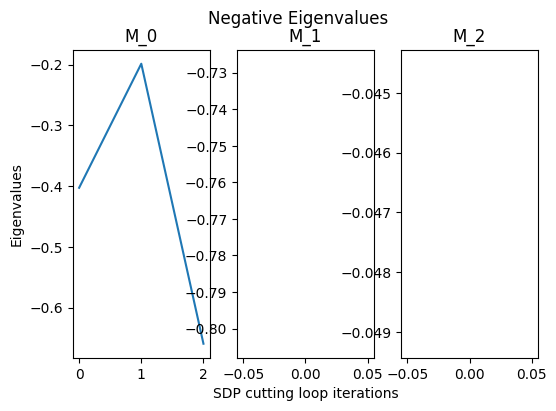

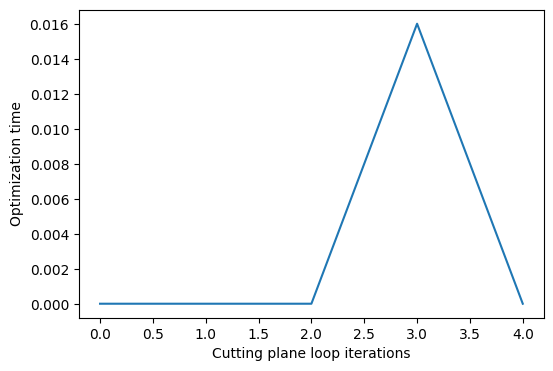

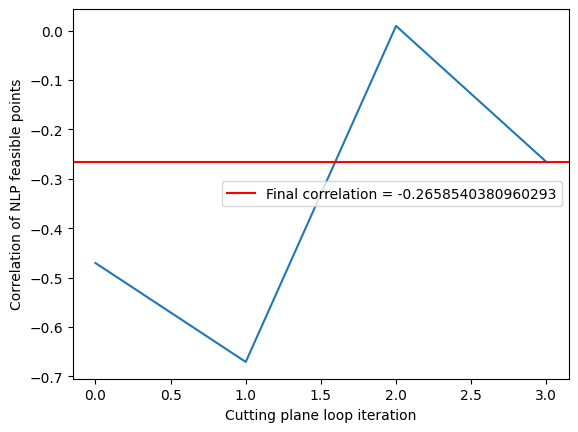

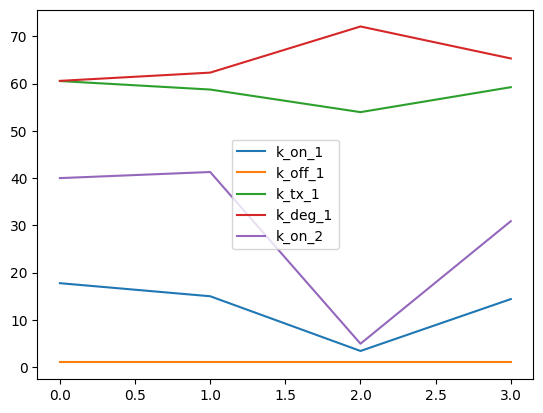

SDP Feasible reaction rates:
k_on_1 = 14.409273699234138
k_off_1 = 1.0
k_tx_1 = 59.23763571760573
k_deg_1 = 65.31642767496663
k_on_2 = 30.89591335175126

(Model) Original correlation
Correlation -0.2658540380960293

(Data) Original correlation
Correlation -0.2914014796139539 
p-value 2.5204759341730167e-21

(Data) Downsampled correlation
Correlation -0.004483235930070079 
p-value 0.4436996571745164



In [105]:
S = 2
result_analysis(S, d, eigenvalues, optim_times, feasible_values, sample, dsample)

### Telegraph data

In [148]:
sample = simulate(k_on=1, k_off=2, k_tx=5, k_deg=1, k_reg=0)

Mean expression [1.743 1.675]


In [149]:
dsample, beta = downsample(sample, mean_capture=0.75)

Mean expression [1.363 1.254]


In [150]:
d = 4
solution, eigenvalues, optim_times, feasible_values = feasibility_BD(dsample, beta, d=d)
solution

{'status': 'INFEASIBLE', 'time': 0.05500006675720215, 'cuts': 0}

In [154]:
S = 2
# result_analysis(S, d, eigenvalues, optim_times, feasible_values, sample, dsample)
# No feasible point, so not values to assess

# OLd

### BD

In [132]:
sample = simulate(k_on=1, k_off=0.0, k_tx=10, k_deg=1, k_reg=0)

Mean expression [ 9.985 10.234]


In [133]:
dsample, beta = downsample(sample, mean_capture=1.0)

Mean expression [ 9.985 10.234]


In [142]:
# bootstrap
N = 1000
d = 5
OB_bounds = bootstrap(sample, d, N)
OB_bounds

array([[1.00000000e+00, 9.78597500e+00, 1.00449750e+01, 1.05609925e+02,
        9.90392000e+01, 1.10409975e+02, 1.23329630e+03, 1.06934140e+03,
        1.08951565e+03, 1.30632552e+03, 1.54185684e+04, 1.24709325e+04,
        1.17404955e+04, 1.28829498e+04, 1.63896043e+04, 2.04577695e+05,
        1.55486031e+05, 1.36651342e+05, 1.38135760e+05, 1.61214229e+05,
        2.17111632e+05],
       [1.00000000e+00, 1.01640000e+01, 1.04181000e+01, 1.13693125e+02,
        1.04743075e+02, 1.18691350e+02, 1.38367082e+03, 1.16489403e+03,
        1.18723312e+03, 1.45507905e+03, 1.81309378e+04, 1.41152802e+04,
        1.31573539e+04, 1.45140613e+04, 1.91114366e+04, 2.55373596e+05,
        1.84418185e+05, 1.58441524e+05, 1.59717647e+05, 1.89751576e+05,
        2.66503307e+05]])

In [140]:
solution, eigenvalues, optim_times = feasibility(dsample, beta, d=4)
solution

{'status': 'OPTIMAL', 'time': 0.18199968338012695, 'cuts': 16}

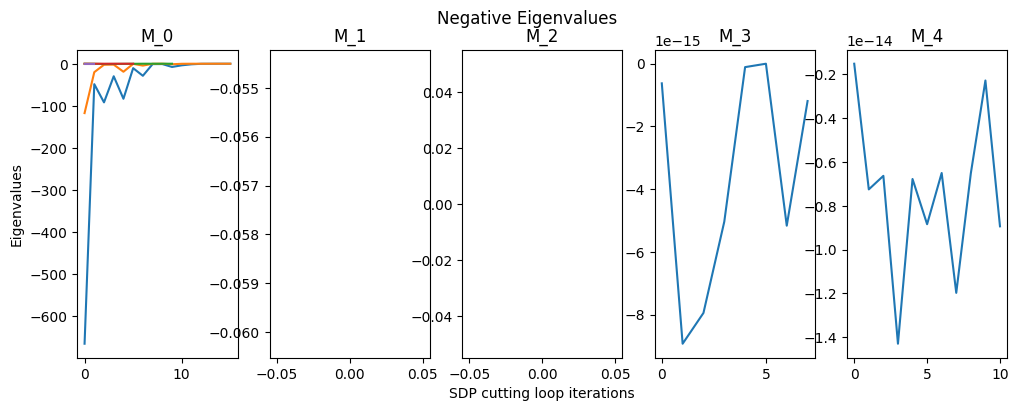

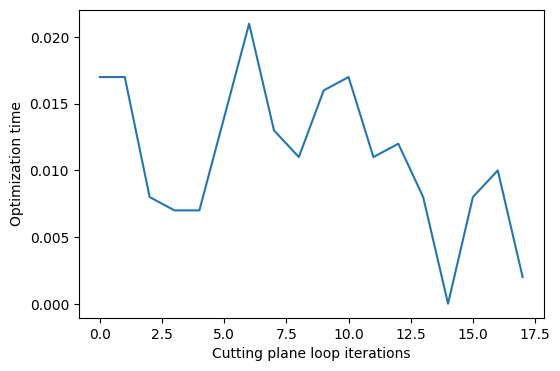

In [141]:
plot_eigenvalues(eigenvalues, log=False)
plot_times(optim_times)

In [167]:
sample = simulate(k_on=1, k_off=0.0, k_tx=1, k_deg=1, k_reg=0)

Mean expression [0.986 1.007]


In [168]:
dsample, beta = downsample(sample, mean_capture=1.0)

Mean expression [0.986 1.007]


In [175]:
solution, eigenvalues, optim_times = feasibility(dsample, beta, d=6)
solution

C:\Users\willi\AppData\Local\Temp\ipykernel_19104\1281715921.py:73: RuntimeWarning: Chained matrix multiplications of MVars is inefficient, collect numeric terms first when building expressions
  model.addConstr(v.T @ variables[f'M_{s}'] @ v >= 0, name=f"Cut_{s}")


{'status': 'OPTIMAL', 'time': 0.4239997863769531, 'cuts': 12}

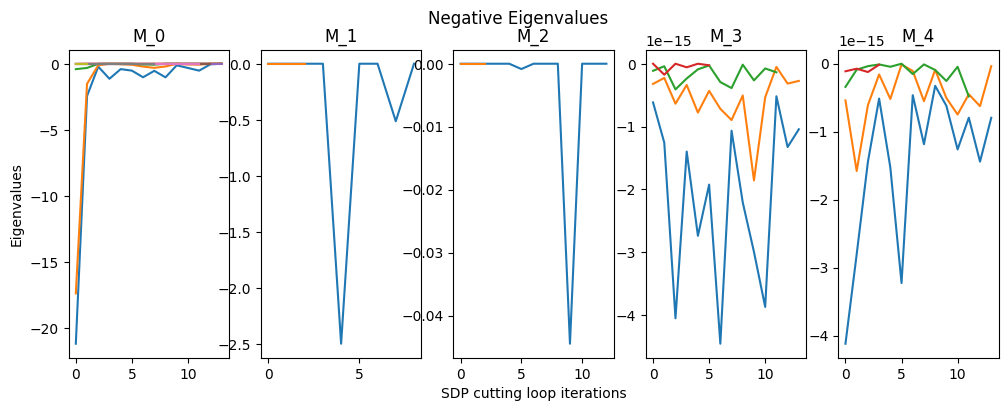

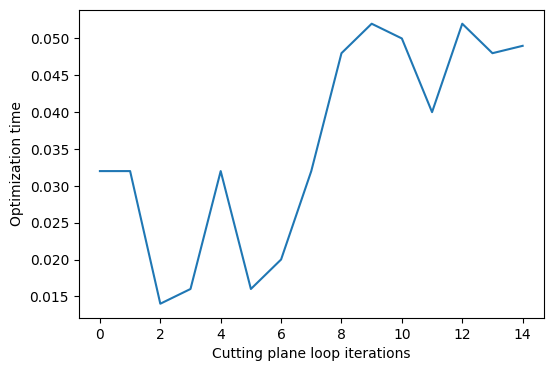

In [170]:
plot_eigenvalues(eigenvalues, log=False)
plot_times(optim_times)

# Independent Telegraph model

In [154]:
sample = simulate(k_on=2, k_off=0.5, k_tx=5, k_deg=1, k_reg=0)

Mean expression [4.026 3.988]


In [155]:
dsample, beta = downsample(sample, mean_capture=1.0)

Mean expression [4.026 3.988]


In [165]:
solution, eigenvalues, optim_times = feasibility_indep(dsample, beta, d=4, cut_limit=100)
solution

{'status': 'OPTIMAL', 'time': 73.94400024414062, 'cuts': 89}

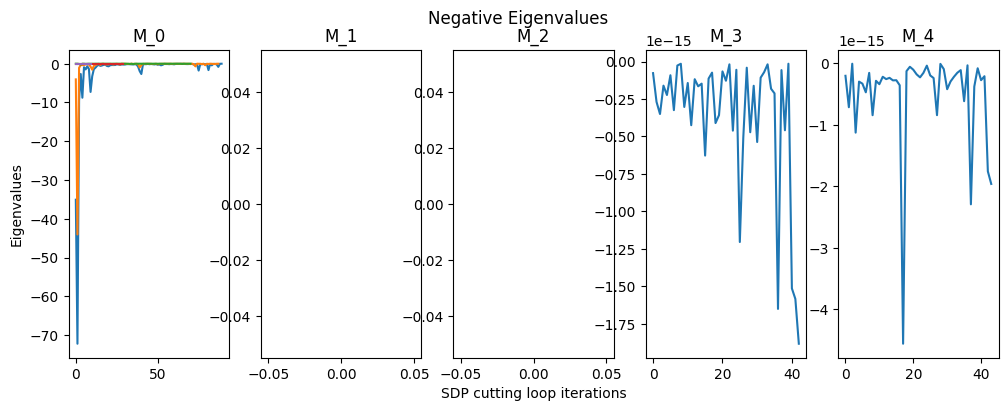

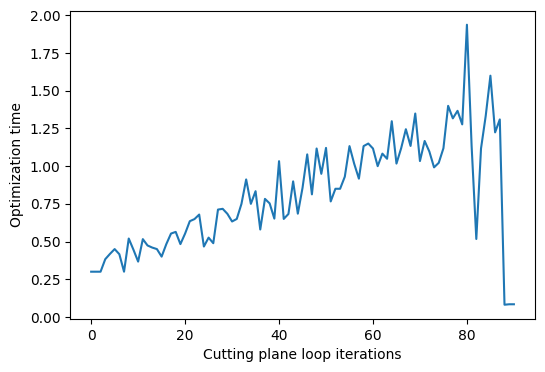

In [166]:
plot_eigenvalues(eigenvalues, log=False)
plot_times(optim_times)

### BD

In [176]:
sample = simulate(k_on=1, k_off=0.0, k_tx=1, k_deg=1, k_reg=0)

Mean expression [1.021 1.01 ]


In [177]:
dsample, beta = downsample(sample, mean_capture=1.0)

Mean expression [1.021 1.01 ]


In [178]:
solution, eigenvalues, optim_times = feasibility_indep(dsample, beta, d=6)
solution

C:\Users\willi\AppData\Local\Temp\ipykernel_19104\1281715921.py:73: RuntimeWarning: Chained matrix multiplications of MVars is inefficient, collect numeric terms first when building expressions
  model.addConstr(v.T @ variables[f'M_{s}'] @ v >= 0, name=f"Cut_{s}")


{'status': 'OPTIMAL', 'time': 297.5990002155304, 'cuts': 55}

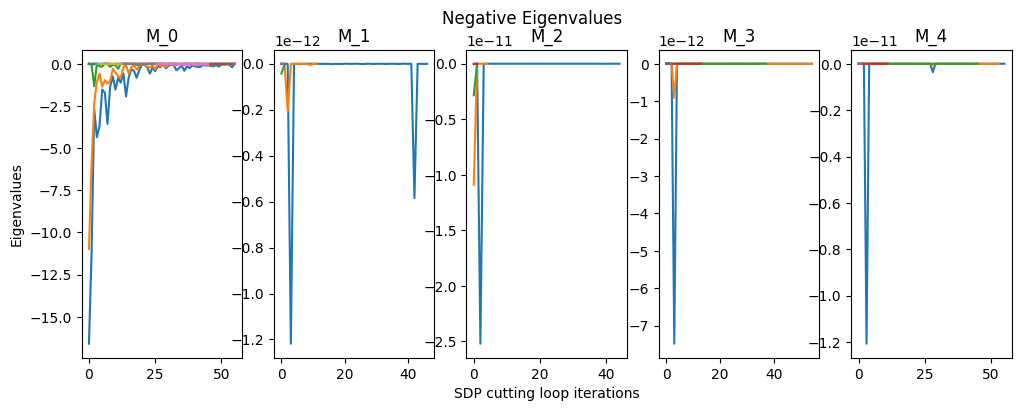

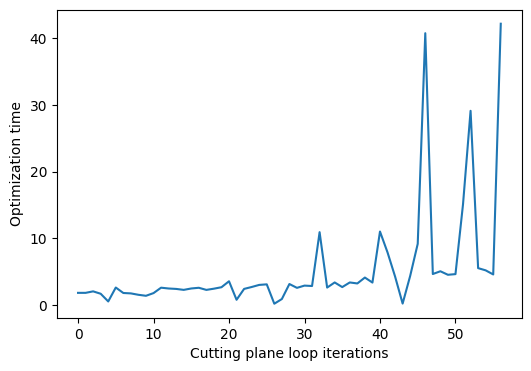

In [179]:
plot_eigenvalues(eigenvalues, log=False)
plot_times(optim_times)

### Interacting

In [184]:
sample = simulate(k_on=2, k_off=0.5, k_tx=5, k_deg=1, k_reg=5)

Mean expression [1.342 1.308]


In [185]:
dsample, beta = downsample(sample, mean_capture=1.0)

Mean expression [1.342 1.308]


In [186]:
solution, eigenvalues, optim_times = feasibility_indep(dsample, beta, d=6)
solution

{'status': 'INFEASIBLE', 'time': 0.0, 'cuts': 0}

# Notes

- d = 4 pretty fast
- d = 6 slow for higher mean expression
- BD data may not be special, just has generally higher mean expression than telegraph (gene always on) so slower
- eigenvalues of M_0 are the most negative, extremely negative initially

Independent TE

- (sufficiently) interacting data immediately infeasible with 0 cuts
- generally seems slower
- variable # cutting planes when re-running on same data (general, but seems more pronounced than for Interacting TE)